In [1]:
"""Import Necessary Libraries"""
import numpy as np
import hottbox
from glob import glob
import math
import seaborn as sns
import pandas as pd
import os.path as op
import mne

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap

import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac, non_negative_parafac, non_negative_parafac_hals, non_negative_tucker, tucker

In [2]:
from matplotlib import cm, colors, colorbar

# Import MNE, as well as the MNE sample dataset
from mne import io
from mne.datasets import sample
from mne.viz import plot_topomap
from mne.time_frequency import psd_welch

# FOOOF imports
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

In [3]:
"""Maps the given string labels to integers"""

gender_map = {'nan':-1, 'Unknown':-1, 'Male':0, 'Female':1}
grade_map = {'nan':-1, 'normal':0, 'abnormal':1}
handed_map = {'nan':-1, 'right':0, 'left':1}
soz_map = {'nan':-1, 'right':0, 'left':1}
epi_map = {'nan':-1, 'unk':-1, 'NC': 0, 'PNES':1, 'DRE':2, 'MRE':3}
alz_map = {'nan':-1, 'unk':-1, 'CN':0, 'MCI':1, 'AD':2}

In [4]:
"""Function for preprocessing one NPZ file"""
def parse_single(npz, average=False):
    
    pib_key = 'pib'
        
    f1 = np.load(npz)
    
    ch_names = [ch.lower() for ch in f1['ch_names']]

    rep_factor = 1 if average else f1['psd'].shape[0]

    raw_psd = np.log10(f1['psd'])

    if average:
        curr_psd = np.expand_dims(np.mean(raw_psd, axis=0), axis=0)
    else:
        curr_psd = raw_psd

    age = np.repeat(f1['age'], rep_factor)
    gender = np.repeat(gender_map[str(f1['gender'])], rep_factor)
    handed = np.repeat(handed_map[str(f1['handed'])], rep_factor)
    sz_side = np.repeat(soz_map[str(f1['sz_side'])], rep_factor)
    grade = np.repeat(grade_map[str(f1['abnormal'])], rep_factor)
    epi_dx = np.repeat(epi_map[str(f1['epilepsy_grp'])], rep_factor)
    alz_dx = np.repeat(alz_map[str(f1['alzheimer_grp'])], rep_factor)
    
    patient_id = np.repeat(f1['subject_id'], rep_factor)
    session_id = np.repeat(f1['session_id'], rep_factor)
    clip_id = np.repeat(f1['clip_id'], rep_factor)
    report = np.repeat(f1['report'], rep_factor)
    
    return {'psd': curr_psd, 'age': age, 'handed': handed, 'sz_side': sz_side, 'grade': grade, 
            'epi_dx': epi_dx, 'alz_dx': alz_dx, 'gender': gender, 'pid': patient_id, 
            'sid': session_id, 'clip_id': clip_id, 'report': report}

from concurrent.futures import ProcessPoolExecutor as Executor

stats_dir = '/mnt/ssd_4tb_0/TUH/processed_yoga/'
all_npz = sorted(glob(stats_dir + '*.npz'))

with Executor(max_workers=30) as executor:
    results = [res for i,res in zip(all_npz, executor.map(parse_single, all_npz))]

In [5]:
"""Stacking/concatenating individual labels/data"""

full_psds = np.vstack([res['psd'] for res in results])
age = np.concatenate([res['age'] for res in results])
gender = np.concatenate([res['gender'] for res in results])
handed = np.concatenate([res['handed'] for res in results])
sz_side = np.concatenate([res['sz_side'] for res in results])
grade = np.concatenate([res['grade'] for res in results])
epi_dx = np.concatenate([res['epi_dx'] for res in results])
alz_dx = np.concatenate([res['alz_dx'] for res in results])

pids = np.concatenate([res['pid'] for res in results])
pids = [str(idx).strip() for idx in pids]
sids = np.concatenate([res['sid'] for res in results])
sids = [str(idx).strip() for idx in sids]
cids = np.concatenate([res['clip_id'] for res in results])
cids = [str(idx).strip() for idx in cids]
reports = np.concatenate([res['report'] for res in results])
reports = [str(rep).strip().lower() for rep in reports]

In [6]:
"""Defining function to plot factors"""

ch_names = ['fp1', 'f3', 'f7', 'c3', 't7', 'p3', 'p7', 'o1', 
            'fp2', 'f4', 'f8', 'c4', 't8', 'p4', 'p8', 'o2',
            'fz', 'cz', 'pz']
ch_names = [ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp') for ch_name in ch_names]
ch_types = ['eeg'] * len(ch_names)
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=256)
info.set_montage('standard_1020')

def plot_factors(factors, d=3, factors_name=["Epochs", "Topomap", "Spectrum"]):

    rank = factors[0].shape[1]
    
    # sns.reset_orig()
    fig, all_axs = plt.subplots(rank, d, figsize=(12, int(rank * 2 + 1)),  sharex="col", sharey="row")
    
    for ind, (factor, axs) in enumerate(zip(factors[:d], all_axs.T)):
        # axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            if ind == 1:
                mne.viz.plot_topomap(f, info, sensors=False, contours=0, cmap=cm.viridis, show=False, axes=ax)
            else:
                sns.despine(top=True, ax=ax)
                ax.plot(f)
            if ind == 2:
                ax.set_xlabel("Frequency (Hz)")
            all_axs[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()
    plt.show()

In [7]:
"""
Plots the box plots of factors for each label
Takes tensor decomp subject factors and labels and outputs the plots
"""

def plot_comparison(factor_ws, labels, title=None):
    
    plt.rcParams["figure.figsize"] = (10,4)
    
    factor_names = ['F'+str(i) for i in range(1, factor_ws.shape[1]+1)]

    fig, ax = plt.subplots(1,1)

    df = pd.DataFrame(factor_ws, columns=factor_names)
    df['class'] = labels
    df_plot = df.melt(id_vars=['class'], var_name='groups', value_name='vals')
    sns.boxplot(data=df_plot, x='groups', y='vals', hue="class", ax=ax)

    plt_ax, test_results = add_stat_annotation(ax, data=df_plot, x='groups', y='vals', hue="class",
                        box_pairs=[((fn, 0), (fn, 1)) for fn in factor_names], 
                        test='Mann-Whitney', show_test_name=False, text_format='star', loc='inside', verbose=0)
    ax.xaxis.label.set_visible(False)
    res_order = [res.__dict__['box1'][0] for res in test_results]
    correct_order = [factor_names.index(fn) for fn in res_order]
    curr_sig = [1 if res.__dict__['pval'] < 0.01 else 0 for res in test_results]
    sig_vals = [curr_sig[ind] for ind in correct_order]
    ax.set_ylabel('Factor Weights')
    if title:
        ax.set_title(title)
    plt.show()
    return np.array(sig_vals)

## Tensor Decomp

In [8]:
decomp_psds = full_psds[(epi_dx == -1) & (alz_dx == -1)]

psds_min = np.min(np.reshape(decomp_psds, [-1]))
psds_max = np.max(np.reshape(decomp_psds, [-1]))
print(psds_min)
print(psds_max)
trans_psds = (decomp_psds - psds_min) / (psds_max - psds_min)
print(trans_psds.shape)

-17.623140950456925
-4.828608060793702
(14052, 19, 45)


In [9]:
"""
Normalizing tensor (between 0 and 1)
Excludes labeled data from decomposition
decomp_psds = full_psds[(epi_dx == -1) & (alz_dx == -1)]

psds_min = np.min(np.reshape(decomp_psds, [-1]))
psds_max = np.max(np.reshape(decomp_psds, [-1]))
trans_psds = (decomp_psds - psds_min) / (psds_max - psds_min)
"""

def rank_one_tensor(a, b, c):
    """Returns a rank 1 tensor, given three vectors  
    """
    a = a.reshape(-1, 1).astype(np.float32)
    b = b.reshape(-1, 1).astype(np.float32)
    c = c.reshape(-1, 1).astype(np.float32)
    return np.tensordot(a * b.T, c, axes=0)[:, :, :, 0]
def reconstruct(factors, rank=None):
    """Reconstructs original tensor from factors"""
    a, b, c = factors
    rank = rank if rank else a.shape[1]
    R1s = np.zeros((a.shape[0], b.shape[0], c.shape[0], rank))
    for i in range(rank):
        R1s[:, :, :, i] = rank_one_tensor(a[:, i], b[:, i], c[:, i])
    return R1s.sum(axis=3)
def fit(X,X_hat):
    """Computes fit score"""
    return 1-np.linalg.norm(X-X_hat)/np.linalg.norm(X)

import TensorFox as tfx

R=3

U = tt.ncp_hals(trans_psds, rank=R, random_state=2737448274,verbose=False) #ptut random state as global
factors_orig = U.factors.factors   
U,_ = tfx.cpd(T=trans_psds, R=R)
factors_orig=tfx.change_sign(U)
X_hat=reconstruct(factors_orig)
fit_i=fit(trans_psds,X_hat)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [10]:
"""Cell to load precomputed factors"""
# factors = np.load("factors_orig1.npz")
# factors_orig = [factors["arr_0"], factors["arr_1"], factors["arr_2"]]

'Cell to load precomputed factors'

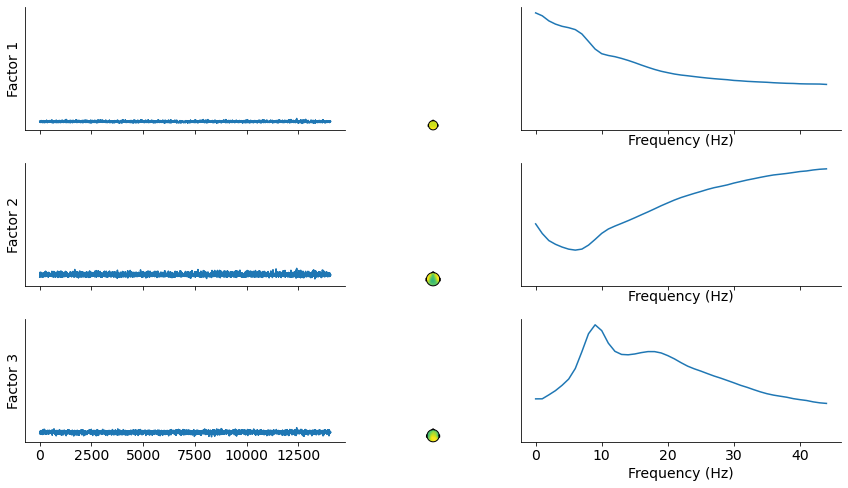

In [11]:
#visualize raw time series for factors 3 and 6 (high and low)
%matplotlib inline 
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
plot_factors(factors_orig, d=3)

### project all data onto the space of factors

In [12]:
#Taking statistic of unlabeled data to be used on unseen data

'''
Here I briefly describe the mathematics behind the reprojection algorithm. 
The first of takes our original tensor and reshape it so that we get a two dimensional tensor.
In other words we reshape the tensor from (N, 19, 45) -> (N, 19x45) (where N is the number of subjects)
Similarly we construct a tensor from our recovered factors that is also two dimensional by taking the 
outer product of the spatial and frequency factors and concatenating.
This constructed tensor is of dimension (5,19x45)

To recover the projected spatial factors we take the reshaped original tensor and multiply it by
the pseudo inverse of the tensor constructed from our recovered factors. This tensor is of dimension 
(N, 5)
'''

trans_psds_full = (full_psds - psds_min) / (psds_max - psds_min)
psds_unrolled = np.reshape(trans_psds_full, [trans_psds_full.shape[0], -1])

factors_unrolled = []
for i in range(factors_orig[0].shape[1]):
    factors_unrolled.append(np.reshape(np.outer(factors_orig[1][:,i], factors_orig[2][:,i]), [-1]))
    
factor_ws = np.matmul(psds_unrolled, np.linalg.pinv(np.array(factors_unrolled)))

factor_ws.shape

(17052, 3)

### normal/abnormal grades - group level comparison across factors

['abnormal' 'abnormal' 'abnormal' ... 'normal' 'normal' 'normal']
Factor Normal: 0.06956118293905508
Factor Abnormal: 0.08098253334469518
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

abnormal v.s. normal: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=6.945e+01
Ttest_indResult(statistic=-69.45394850994252, pvalue=0.0)
['abnormal' 'abnormal' 'abnormal' ... 'normal' 'normal' 'normal']
Factor Normal: 0.06093813838098304
Factor Abnormal: 0.0644490037966091
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

abnormal v.s. normal: t-test independent samples with Bonferroni correction, P_val=2.331e-32 stat=1.187e+01
Ttest_indResult(statistic=-11.871380045837606, pvalue=2.3312236889601555e-32)
['abnormal' 'abnormal' 'abnormal' ... 'normal

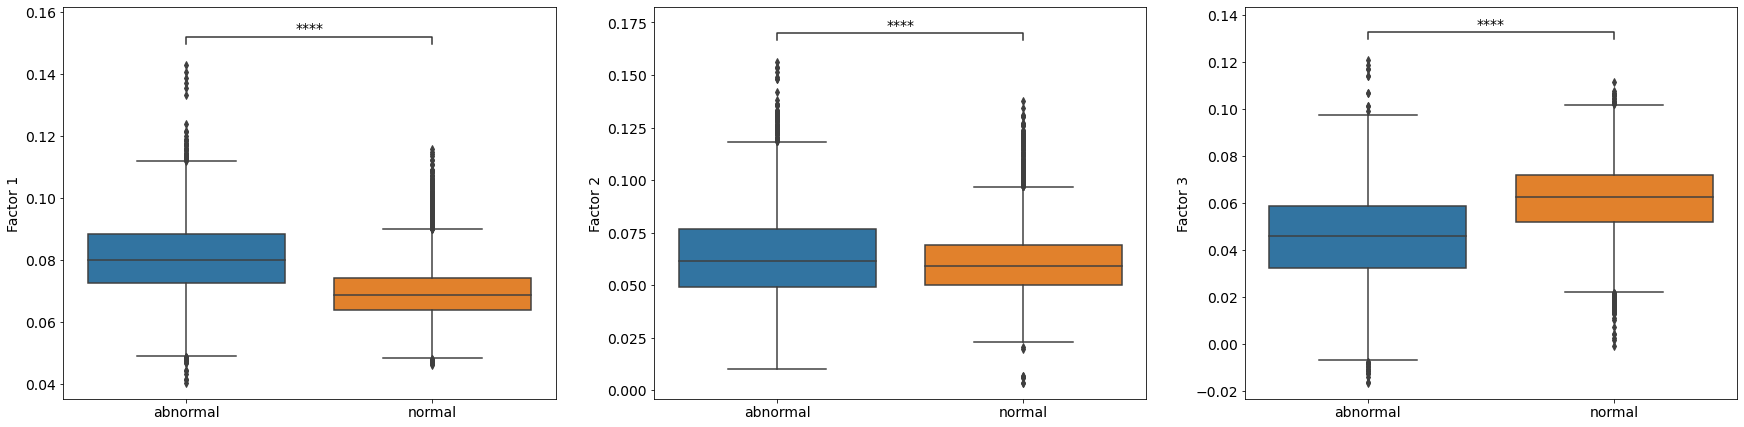

In [13]:
#Look at age distribution of normal versus abnormal patients (look at density estimation or bar plot)
from scipy.stats import kstest,ttest_ind
from scipy.stats import f_oneway
from statannot import add_stat_annotation

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
p_values=[]
fig, ax = plt.subplots(1,R, figsize=(30,7.2))
for i in range(R):
    x=grade[grade >=0]
    x=x.astype(str)
    x[x=='0']="normal"
    x[x=='1']="abnormal"
    y=factor_ws[grade >=0,i]
    df=pd.DataFrame()
    df["abnormal"]= x
    df["factor"]=y
    sns.boxplot(x=x, y=y, ax=ax[i])
    print(x)
    print("Factor Normal:",np.mean(y[x=="normal"]))
    print("Factor Abnormal:",np.mean(y[x=="abnormal"]))

    ax[i].set_ylabel(f"Factor {i+1}", {'fontsize' : 14})
    add_stat_annotation(ax[i],data=df, x="abnormal", y="factor", box_pairs=[("normal","abnormal")],test='t-test_ind', text_format='star')
    stat_test = ttest_ind(y[x=='normal'],y[x=='abnormal'])
    print(stat_test)
    p_values.append(stat_test.pvalue)
plt.show()  

### Age

Correlation Coefficent >30: [[ 1.        -0.0573627]
 [-0.0573627  1.       ]]
Correlation Coefficent: [[ 1.         -0.02812062]
 [-0.02812062  1.        ]]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1 v.s. 2: t-test independent samples with Bonferroni correction, P_val=2.203e-27 stat=1.104e+01
2 v.s. 3: t-test independent samples with Bonferroni correction, P_val=8.424e-03 stat=-3.195e+00
3 v.s. 4: t-test independent samples with Bonferroni correction, P_val=8.016e-02 stat=-2.475e+00
1 v.s. 3: t-test independent samples with Bonferroni correction, P_val=2.025e-15 stat=8.175e+00
2 v.s. 4: t-test independent samples with Bonferroni correction, P_val=7.711e-06 stat=-4.846e+00
1 v.s. 4: t-test independent samples with Bonferroni correction, P_val=7.653e-05 stat=4.369e+00
Correlation Coefficent >30: [[1.         0.07871806]
 [0.07871806 1.        ]]
Correlation Coeffice

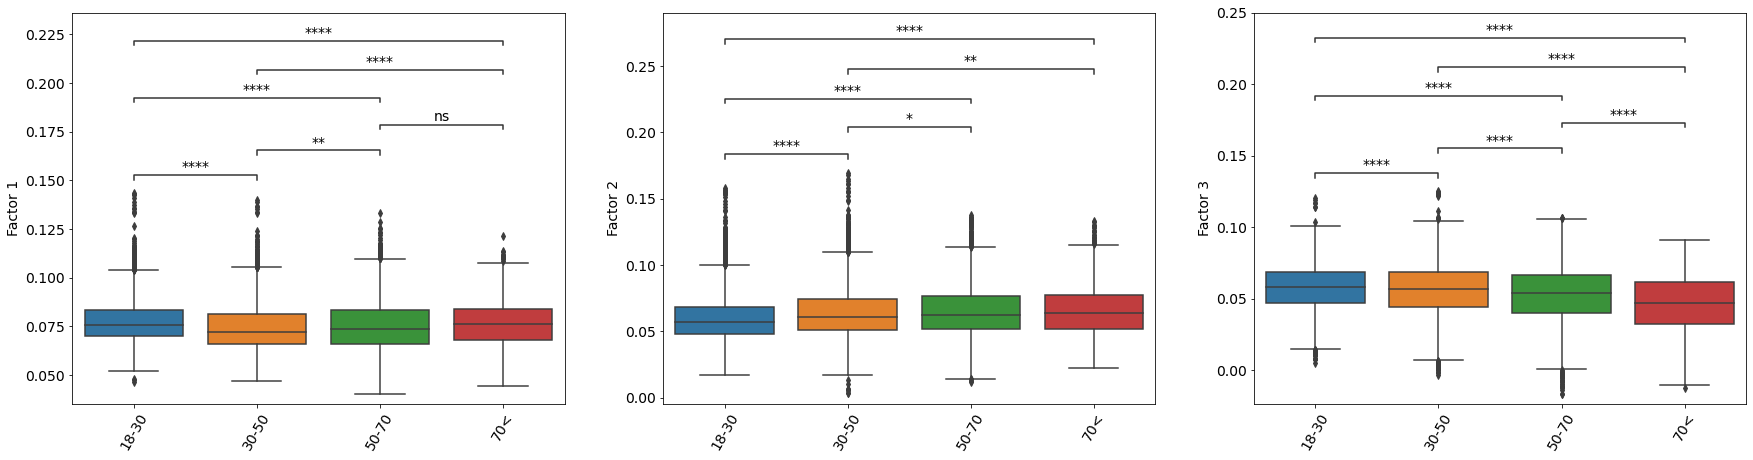

In [14]:
# Group level analysis of different age groups across factors
from scipy.stats import f_oneway
plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
p_values = []
order = [1, 2, 3, 4]
permutations = []
for i in range(len(order)):
    for j in range(i+1,len(order)):
        permutations.append((order[i],order[j]))
fig, ax = plt.subplots(1,R, figsize=(30,7.2))
for i in range(R):
    x = np.digitize(age, np.arange(10, 100, 20))
    filtered_age = age[(grade >= -1)]
    x[x==5] = 4
    x = x[(grade >= -1)]
    y = factor_ws[:,i]
    y = y[(grade >= -1)]
    sns.boxplot(x=x, y=y, ax=ax[i])
    print("Correlation Coefficent >30:", np.corrcoef(x[filtered_age<=70],y[filtered_age<=70]))
    print("Correlation Coefficent:", np.corrcoef(x,y))
    df=pd.DataFrame()
    df["age"]= x
    df["factor"]=y
    ax[i].set_xticks(np.arange(4), ['18-30', '30-50', '50-70', '70<'], rotation=60)
    ax[i].set_ylabel("Factor %d"%(i+1), {'fontsize' : 14})
    group_1= y[x==1]
    group_2= y[x==2]
    group_3= y[x==3]
    group_4= y[(x==4) | (x==5)]
    box_pair=[]
    for permute in permutations:
        if ttest_ind(y[x==permute[0]],y[x==permute[1]]).pvalue<0.05:
            box_pair.append(permute)
    p_values.append(f_oneway(group_1,group_2,group_3,group_4).pvalue)
    add_stat_annotation(ax[i],data=df, x="age", y="factor", box_pairs=box_pair,test='t-test_ind', text_format='star')
plt.show()

In [15]:
#subject factors for all data
np.save("factor_ws.npy",factor_ws)
#epilepsy data
np.save("epi_dx.npy", epi_dx)
#alzheimer's dementia data
np.save("alz_dx.npy", alz_dx)

In [16]:
DATA_DIR= "/home/teja/tensor_decomposition_new/data"
column_names = ['F'+str(i) for i in range(1, factors_orig[0].shape[1]+1)]
df = pd.DataFrame(data=factor_ws, columns=column_names)
df['PID'] = pids
df['SID'] = sids
df['CID'] = cids
df['Age'] = age
df['Grade'] = grade
df['Gender'] = gender
df['Handedness'] = handed
df['Epilepsy'] = epi_dx
df['Alzheimers'] = alz_dx

df = df.sort_values(['PID', 'SID', 'CID'])

df.to_csv(op.join(DATA_DIR,"tensor_decomposition_df.csv"))

### Classification

In [17]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, LeaveOneGroupOut, LeaveOneOut
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_fscore_support,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [18]:
from copy import deepcopy
import pickle
import os
MODEL_DIR = "/home/teja/tensor_decomposition_new/saved_models/"
def classify_LOO(features, labels, clf= GaussianNB(), adjust_sampling_weight=False, save_model= False, save_model_name="None"):

    #clf = GaussianNB()
    clfs=[]
    kf = LeaveOneOut()
    all_y = []
    all_probs=[]
    for train, test in kf.split(features, labels):
        if adjust_sampling_weight:
            sampling_dict = {0:1./np.sum(labels[train]==0), 1:1./np.sum(labels[train]==1)}
            sample_weight = sklearn.utils.class_weight.compute_sample_weight(sampling_dict, labels[train])
            fit_model = clf.fit(features[train], labels[train], sample_weight=sample_weight)
            clfs.append(deepcopy(clf))
        else:
            fit_model = clf.fit(features[train], labels[train])
            clfs.append(deepcopy(clf))
        all_y.append(labels[test])
        all_probs.append(fit_model.predict_proba(features[test])[:,1])
        #print(fit_model.predict_proba(features[test]))
    all_y = np.concatenate(all_y)
    all_probs = np.concatenate(all_probs)
    if save_model:
        model_path = os.path.join(MODEL_DIR,saved_model_name)
        with open(model_path,'wb') as f:
            pickle.dump(clfs,f)
    
    return all_y, all_probs

def classify_Strat(features, labels, clf= GaussianNB(), adjust_sampling_weight=False, folds=15, save_model= False, save_model_name="None"):

    #clf = GaussianNB()
    clfs=[]
    kf = StratifiedKFold(folds)

    all_y = []
    all_probs=[]
    
    auc_scores=[]

    for train, test in kf.split(features, labels):
        if adjust_sampling_weight:
            sampling_dict = {0:1./np.sum(labels[train]==0), 1:1./np.sum(labels[train]==1)}
            sample_weight = sklearn.utils.class_weight.compute_sample_weight(sampling_dict, labels[train])
            fit_model = clf.fit(features[train], labels[train], sample_weight=sample_weight)
            clfs.append(deepcopy(fit_model))
        else:
            fit_model = clf.fit(features[train], labels[train])
            clfs.append(deepcopy(fit_model))
        all_y.append(labels[test])
        all_probs.append(fit_model.predict_proba(features[test])[:,1])
        try:
            auc_scores.append(roc_auc_score(all_y[-1], all_probs[-1]))
        except:
            pass
    print("AUC Mean:",np.mean(auc_scores))
    print("AUC Std:", np.std(auc_scores))
    all_y = np.concatenate(all_y)
    all_probs = np.concatenate(all_probs)
    if save_model:
        model_path = os.path.join(MODEL_DIR,save_model_name)
        with open(model_path,'wb') as f:
            pickle.dump(clfs,f)
    
    return all_y, all_probs

In [19]:
def plot_ROC(ax, all_y, all_probs, title):
    
    fpr, tpr, thresholds = roc_curve(all_y,all_probs)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MC-LOOCV ROC (AUC = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

In [20]:
import numpy as np
from sklearn.metrics import roc_curve

def sensivity_specifity_cutoff(y_true, y_score):
    '''Find data-driven cut-off for classification
    
    Cut-off is determied using Youden's index defined as sensitivity + specificity - 1.
    
    Parameters
    ----------
    
    y_true : array, shape = [n_samples]
        True binary labels.
        
    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).
        
    References
    ----------
    
    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.
    
    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.
    
    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

In [21]:
from scipy.integrate import simps

def compute_welsh_single(spectra):
    lows = [1,4,8,13,25]
    highs = [4,8,13,25,45]
    freq_range = [1, 45]
    freqs = np.arange(freq_range[0], freq_range[1]+1)
    freq_res = freqs[1] - freqs[0]
    bps = []
    for i in range(len(lows)):
        low = lows[i]
        high = highs[i]
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        bp = simps(spectra[:,idx_band], dx=freq_res)
        bp /= simps(spectra[:], dx=freq_res)
        bps.append(bp)
    
    return {"delta_pow":bps[0], "theta_pow":bps[1], "alpha_pow": bps[2],
           "beta_pow":bps[3], "gamma_pow":bps[4]}

In [22]:
def compute_fooof_single(spectra):
    
    # Initialize a FOOOFGroup object, with desired settings
    fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.15,
                    peak_threshold=2., max_n_peaks=6, verbose=False)

    # Define the frequency range to fit
    freq_range = [1, 45]

    # Fit the power spectrum model across all channels
    fg.fit(freqs, spectra, freq_range)
    
    cfs = fg.get_params('peak_params', 'CF')
    exps = fg.get_params('aperiodic_params', 'exponent')
    
    delta_pow = get_band_peak_fg(fg, [1, 4])[:, 1]
    theta_pow = get_band_peak_fg(fg, [4, 8])[:, 1] ## (each row is [CF, PW, BW])
    alpha_pow = get_band_peak_fg(fg, [8, 13])[:, 1]
    beta_pow = get_band_peak_fg(fg, [13, 25])[:, 1]
    gamma_pow= get_band_peak_fg(fg, [25, 45])[:, 1]
    
    return {'cfs': cfs, 'exps': exps,'delta_pow':delta_pow ,
            'theta_pow': theta_pow, 'alpha_pow': alpha_pow, 'beta_pow': beta_pow, 'gamma_pow':gamma_pow}

In [23]:
combined_psds = np.reshape(full_psds, [-1, 45])
spectra = 10 ** combined_psds
freqs = np.arange(1, 46)

list_psds = [10 ** full_psds[i] for i in range(full_psds.shape[0])]

In [24]:
with Executor(max_workers=30) as executor:
    results = [res for i,res in zip(list_psds, executor.map(compute_welsh_single, list_psds))]

In [25]:
delta_pows=[]
theta_pows=[]
alpha_pows=[]
beta_pows=[]
gamma_pows=[]

for i in range(len(results)):
    delta_pows.append(results[i]['delta_pow'].reshape(1,-1))
    theta_pows.append(results[i]['theta_pow'].reshape(1,-1))
    alpha_pows.append(results[i]['alpha_pow'].reshape(1,-1))
    beta_pows.append(results[i]['beta_pow'].reshape(1,-1))
    gamma_pows.append(results[i]['gamma_pow'].reshape(1,-1))
delta_pows=np.concatenate(delta_pows)
theta_pows=np.concatenate(theta_pows)
alpha_pows=np.concatenate(alpha_pows)
beta_pows=np.concatenate(beta_pows)
gamma_pows=np.concatenate(gamma_pows)

band_pows= np.concatenate([delta_pows, theta_pows, alpha_pows, beta_pows, gamma_pows],axis=1)
np.save("/home/teja/tensor_decomposition_new/data/welsh_band_pows.npy", band_pows)


In [26]:
band_pows=np.load("/home/teja/tensor_decomposition_new/data/welsh_band_pows.npy", allow_pickle=True)

### AD

In [27]:
cls_df = df.copy()
epilepsy_df = cls_df.copy()[cls_df['Epilepsy']>=0]

ad_df = cls_df.copy()[cls_df['Alzheimers']>=0]

ad_df['MCI_vs_all'] = (ad_df['Alzheimers'] == 1).astype(int)
ad_df['AD_vs_all'] = (ad_df['Alzheimers'] == 2).astype(int)

all_ad={}
all_mci={}

## AD TD Naive Bayes

In [28]:
used_factors = ['F1',
                'F2',
                'F3',
                #'F4',
                #'F5',
               ]

sub_df = ad_df[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
#features = sub_df[used_factors].values
labels = sub_df.groupby(['PID']).mean()['MCI_vs_all'].values
#labels = sub_df['MCI_vs_all'].values
y_mci, probs_mci = classify_Strat(features, labels, clf=GaussianNB(var_smoothing=0.1), save_model=True, save_model_name="td_gnb_mci" )
all_mci["y_td_gb"]=y_mci
all_mci["probs_td_gb"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(y_mci,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mci,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_df = ad_df[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
#features = sub_df[used_factors].values
labels = sub_df.groupby(['PID']).mean()['AD_vs_all'].values
#labels = sub_df['AD_vs_all'].values
y_ad, probs_ad = classify_Strat(features, labels, clf=GaussianNB(var_smoothing=0.1), save_model=True, save_model_name="td_gnb_ad" )
all_ad["y_td_gb"]=y_ad
all_ad["probs_td_gb"]= probs_ad
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(y_ad,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_ad,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.56)
# MCI vs CN (Bal. ACC: 0.55)
# AD vs CN (ACC: 0.77)
# AD vs CN (Bal. ACC: 0.76)

AUC Mean: 0.65
AUC Std: 0.32659863237109044
MCI vs CN (ACC: 0.62)
MCI vs CN (Bal. ACC: 0.59)
AUC Mean: 0.8944444444444444
AUC Std: 0.1594744454934147
AD vs CN (ACC: 0.80)
AD vs CN (Bal. ACC: 0.81)


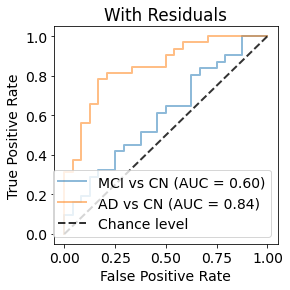

In [29]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## AD TD SVM

In [30]:
used_factors = ['F1',
                'F2',
                'F3',
                #'F4',
                #'F5',
               ]

sub_df = ad_df[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
#features = sub_df[used_factors].values
labels = sub_df.groupby(['PID']).mean()['MCI_vs_all'].values
#labels = sub_df['MCI_vs_all'].values
y_mci, probs_mci = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"))#, save_model=True, save_model_name="td_svm_mci" )
all_mci["y_td_gb"]=y_mci
all_mci["probs_td_gb"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(y_mci,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mci,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_df = ad_df[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
#features = sub_df[used_factors].values
labels = sub_df.groupby(['PID']).mean()['AD_vs_all'].values
#labels = sub_df['AD_vs_all'].values
y_ad, probs_ad = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"))#, save_model=True, save_model_name="td_svm_ad" )
all_ad["y_td_gb"]=y_ad
all_ad["probs_td_gb"]= probs_ad
acc = accuracy_score(y_ad,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_ad,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.64)
# MCI vs CN (Bal. ACC: 0.63)
# AD vs CN (ACC: 0.73)
# AD vs CN (Bal. ACC: 0.72)

AUC Mean: 0.3722222222222222
AUC Std: 0.299485154932079
MCI vs CN (ACC: 0.45)
MCI vs CN (Bal. ACC: 0.52)
AUC Mean: 0.9166666666666666
AUC Std: 0.149071198499986
AD vs CN (ACC: 0.68)
AD vs CN (Bal. ACC: 0.70)


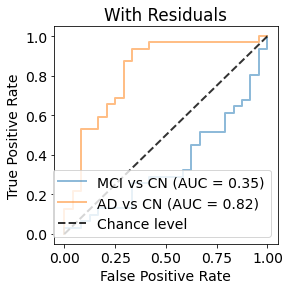

In [31]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## AD TD NN

In [32]:
used_factors = ['F1',
                'F2',
                'F3',
                #'F4',
                #'F5',
               ]

sub_df = ad_df[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
#features = sub_df[used_factors].values
labels = sub_df.groupby(['PID']).mean()['MCI_vs_all'].values
#labels = sub_df['MCI_vs_all'].values
y_mci, probs_mci = classify_Strat(features, labels, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True), save_model=True, save_model_name="td_nn_mci")
all_mci["y_td_gb"]=y_mci
all_mci["probs_td_gb"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(y_mci,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mci,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_df = ad_df[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
#features = sub_df[used_factors].values
labels = sub_df.groupby(['PID']).mean()['AD_vs_all'].values
#labels = sub_df['AD_vs_all'].values
y_ad, probs_ad = classify_Strat(features, labels, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True), save_model=True, save_model_name="td_nn_ad")
all_ad["y_td_gb"]=y_ad
all_ad["probs_td_gb"]= probs_ad
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(y_ad,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_ad,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.53)
# MCI vs CN (Bal. ACC: 0.52)
# AD vs CN (ACC: 0.57)
# AD vs CN (Bal. ACC: 0.54)

AUC Mean: 0.5444444444444444
AUC Std: 0.3289526965130547
MCI vs CN (ACC: 0.56)
MCI vs CN (Bal. ACC: 0.54)
AUC Mean: 0.5222222222222223
AUC Std: 0.38062651406579195
AD vs CN (ACC: 0.54)
AD vs CN (Bal. ACC: 0.54)


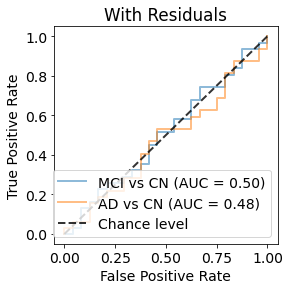

In [33]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Alzheimers PSDS

In [34]:
band_pows= pd.DataFrame(band_pows)
band_pows=band_pows.fillna(0)
band_pows['PID']=epilepsy_df['PID']
ad_psds= band_pows.copy()[cls_df['Alzheimers']>=0]
ad_psds['PID']= ad_df['PID']
ad_psds['MCI_vs_all']= (ad_df['Alzheimers'] == 1).astype(int)
ad_psds['AD_vs_all']= (ad_df['Alzheimers'] == 2).astype(int)

/tmp/ipykernel_2367244/670001340.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ad_psds= band_pows.copy()[cls_df['Alzheimers']>=0]


## Alzheimers PSDS (Gaussian Naive Bayes)

In [35]:
used_factors=np.arange(95)
sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['MCI_vs_all'].values
y_mci, probs_mci = classify_Strat(features, labels, clf=GaussianNB(var_smoothing=0.1), save_model=True, save_model_name="psd_gnb_mci")
all_mci["y_psd_gb"]=y_mci
all_mci["probs_psd_gb"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(y_mci,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mci,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['AD_vs_all'].values
y_ad, probs_ad = classify_Strat(features, labels, clf=GaussianNB(var_smoothing=0.1), save_model=True, save_model_name="psd_gnb_ad")
all_ad["y_psd_gb"]=y_ad
all_ad["probs_psd_gb"]= probs_ad
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(y_ad,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_ad,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.55)
# MCI vs CN (Bal. ACC: 0.59)
# AD vs CN (ACC: 0.86)
# AD vs CN (Bal. ACC: 0.85)

AUC Mean: 0.4944444444444444
AUC Std: 0.38425814368423516
MCI vs CN (ACC: 0.53)
MCI vs CN (Bal. ACC: 0.57)
AUC Mean: 0.9166666666666666
AUC Std: 0.149071198499986
AD vs CN (ACC: 0.80)
AD vs CN (Bal. ACC: 0.81)


/tmp/ipykernel_2367244/1288872897.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
/tmp/ipykernel_2367244/1288872897.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]


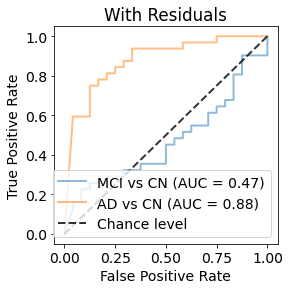

In [36]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Alzheimers PSD (Classical Machine Learning)

In [37]:
used_factors=np.arange(95)
sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['MCI_vs_all'].values
y_mci, probs_mci = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"), save_model=True, save_model_name="psd_svm_mci")
all_mci["y_psd_svm"]=y_mci
all_mci["probs_psd_svm"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(y_mci,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mci,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['AD_vs_all'].values
y_ad, probs_ad = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"), save_model=True, save_model_name="psd_svm_ad")
all_ad["y_psd_svm"]=y_ad
all_ad["probs_psd_svm"]= probs_ad
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(y_ad, (probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_ad, (probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.67)
# MCI vs CN (Bal. ACC: 0.65)
# AD vs CN (ACC: 0.80)
# AD vs CN (Bal. ACC: 0.81)

AUC Mean: 0.65
AUC Std: 0.3511884584284246
MCI vs CN (ACC: 0.71)
MCI vs CN (Bal. ACC: 0.72)
AUC Mean: 0.861111111111111
AUC Std: 0.18425693279752223
AD vs CN (ACC: 0.80)
AD vs CN (Bal. ACC: 0.81)


/tmp/ipykernel_2367244/3571102360.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
/tmp/ipykernel_2367244/3571102360.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]


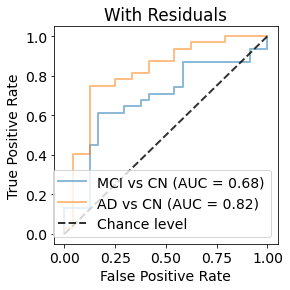

In [38]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Alzheimers PSD (Neural Network)

In [39]:
used_factors=np.arange(95)
sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['MCI_vs_all'].values
y_mci, probs_mci = classify_Strat(features, labels, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True), save_model=True, save_model_name="psd_nn_mci")
all_mci["y_psd_nn"]=y_mci
all_mci["probs_psd_nn"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(y_mci,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mci,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['AD_vs_all'].values
y_ad, probs_ad = classify_Strat(features, labels, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True), save_model=True, save_model_name="psd_nn_ad")
all_ad["y_psd_nn"]=y_mci
all_ad["probs_psd_nn"]= probs_mci
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(y_ad,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_ad,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.56)
# MCI vs CN (Bal. ACC: 0.57)

# AD vs CN (ACC: 0.75)
# AD vs CN (Bal. ACC: 0.77)


/tmp/ipykernel_2367244/1282302211.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]


AUC Mean: 0.6388888888888888
AUC Std: 0.3697680287176386
MCI vs CN (ACC: 0.65)
MCI vs CN (Bal. ACC: 0.63)


/tmp/ipykernel_2367244/1282302211.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]


AUC Mean: 0.9
AUC Std: 0.17795130420052185
AD vs CN (ACC: 0.84)
AD vs CN (Bal. ACC: 0.84)


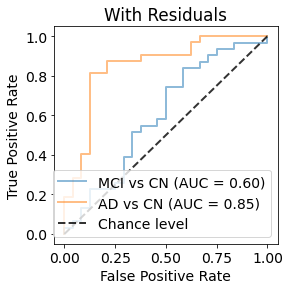

In [40]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Alzheimer's SL

In [41]:
import numpy as np
import pandas as pd
embeddings = np.load("/home/teja/tensor_decomposition_new/saved_embeddings/57f14ebfacd34476ad20000ecdd52c54_td.embeddings.npy")
alz_dx = pd.read_csv("/home/teja/tensor_decomposition_new/metadata/td_index1.csv")["alz_dx"]
subject_ids = pd.read_csv("/home/teja/tensor_decomposition_new/metadata/td_index1.csv")["subject_id"]
subject_ids = subject_ids[alz_dx>=0]
alz_embeddings = embeddings[alz_dx>=0]
alz_dx = alz_dx[alz_dx>=0]
mci_vs_all = (alz_dx==1).astype(int)
ad_vs_all = (alz_dx==2).astype(int)

## Alzheimer's SL (Gaussian Naive Bayes)

In [42]:
def create_mask(subject_labels,ids):
    mask = (subject_labels == ids[0])
    
    for i in range(1,len(ids)):
        mask = mask | (subject_labels == ids[i])
    return mask

def classify_LOO_1(features, labels, subject_ids,clf= GaussianNB(), adjust_sampling_weight=False, folds=15, save_model=False, save_model_name="None"):

    clfs=[]
    unique_subject_ids = np.unique(subject_ids)
    unique_labels=[]
    for id_ in unique_subject_ids:
        unique_labels.append(np.mean(labels[subject_ids == id_ ]))
    unique_labels = np.array(unique_labels)
        
    kf = StratifiedKFold(folds)

    all_y = []
    all_probs=[]
    auc_scores=[]

    for train,test in kf.split(unique_subject_ids,unique_labels):
        train_mask = create_mask(subject_ids, unique_subject_ids[train])
        test_mask =  create_mask(subject_ids, unique_subject_ids[test])
        if adjust_sampling_weight:
            sampling_dict = {0:1./np.sum(labels[train_mask]==0), 1:1./np.sum(labels[train_mask]==1)}
            sample_weight = sklearn.utils.class_weight.compute_sample_weight(sampling_dict, labels[train_mask])
            fit_model = clf.fit(features[train_mask], labels[train_mask], sample_weight=sample_weight)
            clfs.append(deepcopy(fit_model))
        else:
            fit_model = clf.fit(features[train_mask], labels[train_mask])
            clfs.append(deepcopy(fit_model))
        test_y=[]
        test_probs=[]
        for subject_id in unique_subject_ids[test]:
            all_y.append(unique_labels[unique_subject_ids == subject_id])
            all_probs.append(np.mean(fit_model.predict_proba(features[subject_ids == subject_id])[:,1]))
            test_y.append(unique_labels[unique_subject_ids == subject_id])
            test_probs.append(np.mean(fit_model.predict_proba(features[subject_ids == subject_id])[:,1]))
#         print(test_y)
#         print(test_probs)
        auc_scores.append(roc_auc_score(test_y,test_probs))
    print("AUC Mean:",np.mean(auc_scores))
    print("AUC Std:",np.std(auc_scores))
    all_y = np.array(all_y).astype(int)
    all_probs = np.array(all_probs)
    if save_model:
        model_path = os.path.join(MODEL_DIR,save_model_name)
        with open(model_path,'wb') as f:
            pickle.dump(clfs,f)
    
    return all_y, all_probs

In [43]:
sub_embeddings = alz_embeddings[(alz_dx==0)|(alz_dx==1)]
sub_labels= mci_vs_all[(alz_dx==0)|(alz_dx==1)]
sub_ids= subject_ids[(alz_dx==0)|(alz_dx==1)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_mci, probs_mci = classify_LOO_1(features, labels,sub_ids, clf=GaussianNB(var_smoothing=0.1), save_model=True, save_model_name="ssl_gnb_mci")
# print(y_mci)
# print(probs_mci)
labels=y_mci
all_mci["y_sl_gb"]=y_mci
all_mci["probs_sl_gb"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(labels,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_embeddings = alz_embeddings[(alz_dx==0)|(alz_dx==2)]
sub_labels= ad_vs_all[(alz_dx==0)|(alz_dx==2)]
sub_ids= subject_ids[(alz_dx==0)|(alz_dx==2)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_ad, probs_ad = classify_LOO_1(features, labels,sub_ids, adjust_sampling_weight=True, clf=GaussianNB(var_smoothing=0.1), save_model=True, save_model_name="ssl_gnb_ad")
labels=y_ad
all_ad["y_sl_gb"]=y_ad
all_ad["probs_sl_gb"]= probs_ad
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(labels,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.49)
# MCI vs CN (Bal. ACC: 0.53)
# AD vs CN (ACC: 0.73)
# AD vs CN (Bal. ACC: 0.75)

AUC Mean: 0.45
AUC Std: 0.4
MCI vs CN (ACC: 0.51)
MCI vs CN (Bal. ACC: 0.55)
AUC Mean: 0.6944444444444445
AUC Std: 0.33147630867058436
AD vs CN (ACC: 0.71)
AD vs CN (Bal. ACC: 0.73)


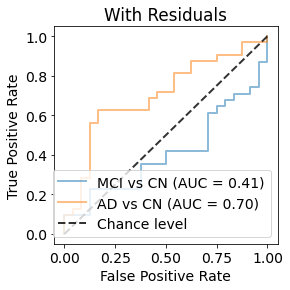

In [44]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Alzheimer's SL (Classical Machine Learning)

In [45]:
sub_embeddings = alz_embeddings[(alz_dx==0)|(alz_dx==1)]
sub_labels= mci_vs_all[(alz_dx==0)|(alz_dx==1)]
sub_ids= subject_ids[(alz_dx==0)|(alz_dx==1)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_mci, probs_mci = classify_LOO_1(features, labels,sub_ids, clf=SVC(probability=True, class_weight="balanced"), save_model=True, save_model_name="ssl_svm_mci")
labels=y_mci
all_mci["y_sl_svm"]=y_mci
all_mci["probs_sl_svm"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(labels,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_embeddings = alz_embeddings[(alz_dx==0)|(alz_dx==2)]
sub_labels= ad_vs_all[(alz_dx==0)|(alz_dx==2)]
sub_ids= subject_ids[(alz_dx==0)|(alz_dx==2)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_ad, probs_ad = classify_LOO_1(features, labels,sub_ids, clf=SVC(probability=True, class_weight="balanced"), save_model=True, save_model_name="ssl_svm_ad")
labels=y_ad
all_ad["y_sl_svm"]=y_ad
all_ad["probs_sl_svm"]= probs_ad
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(labels,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.58)
# MCI vs CN (Bal. ACC: 0.56)
# AD vs CN (ACC: 0.68)
# AD vs CN (Bal. ACC: 0.70)

AUC Mean: 0.5277777777777778
AUC Std: 0.3491612524993482
MCI vs CN (ACC: 0.58)
MCI vs CN (Bal. ACC: 0.56)
AUC Mean: 0.6666666666666666
AUC Std: 0.2755465948363832
AD vs CN (ACC: 0.68)
AD vs CN (Bal. ACC: 0.69)


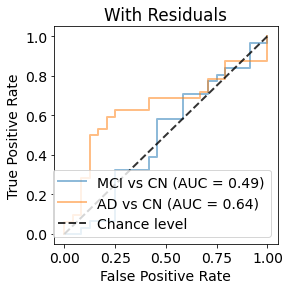

In [46]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Alzheimer's SL (Neural Network)

In [47]:
sub_embeddings = alz_embeddings[(alz_dx==0)|(alz_dx==1)]
sub_labels= mci_vs_all[(alz_dx==0)|(alz_dx==1)]
print(len(subject_ids), len(alz_dx))
sub_ids= subject_ids[(alz_dx==0)|(alz_dx==1)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_mci, probs_mci = classify_LOO_1(features, labels,sub_ids, clf=MLPClassifier(hidden_layer_sizes=(200,), max_iter=100000, early_stopping=True))#, save_model=True, save_model_name="ssl_nn_mci")
labels=y_mci
all_mci["y_sl_nn"]=y_mci
all_mci["probs_sl_nn"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(labels,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_embeddings = alz_embeddings[(alz_dx==0)|(alz_dx==2)]
sub_labels= ad_vs_all[(alz_dx==0)|(alz_dx==2)]
sub_ids= subject_ids[(alz_dx==0)|(alz_dx==2)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_ad, probs_ad = classify_LOO_1(features, labels,sub_ids, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True))#, save_model=True, save_model_name="ssl_nn_ad")
labels=y_ad
all_ad["y_sl_nn"]=y_ad
all_ad["probs_sl_nn"]= probs_ad
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(labels,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.60)
# MCI vs CN (Bal. ACC: 0.60)
# AD vs CN (ACC: 0.73)
# AD vs CN (Bal. ACC: 0.73)

630 630
AUC Mean: 0.5777777777777777
AUC Std: 0.34756649599149003
MCI vs CN (ACC: 0.62)
MCI vs CN (Bal. ACC: 0.61)
AUC Mean: 0.7333333333333333
AUC Std: 0.2873892701417236
AD vs CN (ACC: 0.66)
AD vs CN (Bal. ACC: 0.68)


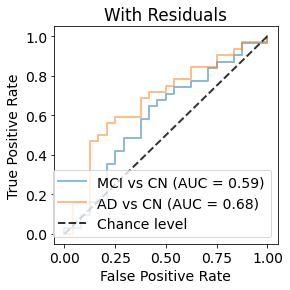

In [48]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()